In [1]:
import rpyc
c = rpyc.classic.connect("localhost", 1300)
c._config["sync_request_timeout"] = 300  # Set timeout to higher level
CtxDynapse = c.modules.CtxDynapse

In [3]:
import numpy as np
import json
import pandas

from neuromorphicOscillatorsForPacemakers.ECG.ECGRecoding import ECGRecording
from neuromorphicOscillatorsForPacemakers.CPG_model.NetworkParams import NetworkParams
from neuromorphicOscillatorsForPacemakers.CPG_model.set_up_MultiOscs import set_up_MultiOscs
from neuromorphicOscillatorsForPacemakers.utils.utils_dynapse.MyDynapseNeuron import MyDynapseNeuron
from neuromorphicOscillatorsForPacemakers.utils.utils_dynapse.DynapseOffSwitcher import DynapseOffSwitcher
from neuromorphicOscillatorsForPacemakers.utils.utils_dynapse.BiasSaver import BiasSaver

from neuromorphicOscillatorsForPacemakers.utils.utils_tuning.utils_tuningPreparation import clean_dynapse, set_not_used_neurons_to_tau2
from neuromorphicOscillatorsForPacemakers.utils.utils_tuning.utils_hardwareTuning import set_biases
from neuromorphicOscillatorsForPacemakers.utils.utils_tuning.RSAInputTuner import RSAInputTuner
from neuromorphicOscillatorsForPacemakers.utils.utils_dynapse.FPGAEventGenerator import FPGAEventGenerator
from neuromorphicOscillatorsForPacemakers.utils.utils_tuning.RSASpiketrainGenerator import RSASpiketrainGenerator
from neuromorphicOscillatorsForPacemakers.utils.utils_visualization.RSAOscSummaryPlotter import RSAOscSummaryPlotter
from neuromorphicOscillatorsForPacemakers.utils.utils_dynapse.OscEventsSaver import OscEventsSaver

DynOff = DynapseOffSwitcher(CtxDynapse=CtxDynapse)

WARNING    /home/renate/Dropbox/src/teili/teili/__init__.py:10: UserWarning: No method using pyqtgraph can be used as pyqtgraph or PyQt5can't be imported.
  warnings.warn("No method using pyqtgraph can be used as pyqtgraph or PyQt5"
 [py.warnings]


## Shared parameters / constants

In [3]:
N_osc = 3
cores_per_chip = 4

# parameters to create population activity trace
dt = 10.
tau = 0.05*1e6
thr_exc = 8.
thr_inh = 1.

# DC to Frequency parameters
path_to_optParams_DC2Freq = 'optParams_sweepIF_DC_P.json'
with open(path_to_optParams_DC2Freq, 'r') as infile:
    params_DC2Freq = json.load(infile)
params_DC2Freq = [params_DC2Freq[str(osc_nr)] for osc_nr in range(N_osc)]

# DYNAP-SE biases
path_to_biases = 'bias_sets/dynapse_biases.json'
MyBiasSaver = BiasSaver(base_dir_biases='')

# parameters inhInput RSA (params for osc_inv to get input spike rate (osc_inv(c) --> breathing_coeff to input spike frequency))
path_to_optParams_inhInpRSA = 'optParams_sweep_inhFR_RSA.json'
with open(path_to_optParams_inhInpRSA, 'r') as infile:
    params_inhInpRSA = json.load(infile)
params_inhInpRSA = [params_inhInpRSA[str(osc_nr)] for osc_nr in range(N_osc)]

## prepare and reset dynapse

In [4]:
dynapse_model = CtxDynapse.model
clean_dynapse(CtxDynapse=CtxDynapse, chips_to_clean=[0,1,2,3])
print('CAMs cleared')

CAMs cleared


## set up connections

In [5]:
NetParams = NetworkParams(CtxDynapse, N_osc=N_osc)
MyOscs = set_up_MultiOscs(NetParams=NetParams, c=c, CtxDynapse=CtxDynapse)

Add excA2excB connections
Add inhA2inhB connections
Connections setup and applied


## set up spikegen

In [6]:
seed_nr_poisson                  = 42
syn_type_spikegen_ctxtctr        = CtxDynapse.DynapseCamType.FAST_INH
target_neuron_ids_global_per_osc = NetParams.neuron_ids_global_pops_exc
conn_strength                    = 1
virtual_neuron_ids               = [1]
MyOscs.set_up_spikegenerator()
MyOscs.add_connections_to_spikegenerator(virtual_neuron_ids=virtual_neuron_ids, target_neuron_ids_global_per_osc=target_neuron_ids_global_per_osc,
                                         syn_type=syn_type_spikegen_ctxtctr, conn_strength=conn_strength)

# add read out connection (to see when spike gen starts)
readout_chip_id       = 1
readout_core_id       = 0
readout_core_mask     = 15
readout_syn_type      = [CtxDynapse.DynapseCamType.FAST_EXC]
readout_conn_strength = 32
readout_neuron_id_global    = MyDynapseNeuron(chip_id=readout_chip_id, core_id=readout_core_id, column_nr_core=8, row_nr_core=8).neuron_id_global
readout_neuron_id_chiplevel = MyDynapseNeuron(chip_id=readout_chip_id, core_id=readout_core_id, column_nr_core=8, row_nr_core=8).neuron_id_core
readout_neurons_dynapse     = [MyOscs.dynapse_neurons[readout_neuron_id_global]]
MyOscs.connector.add_connection_from_list([MyOscs.virtual_neurons[virtual_neuron_ids[0]]]*conn_strength, readout_neurons_dynapse*conn_strength, readout_syn_type*conn_strength)
MyOscs.dynapse_model.apply_diff_state()

isi_base  = 900
unit_mult = isi_base / 90
MyOscs.spikegen.set_isi_multiplier(isi_base)

ADDR_NUM_BITS = 15
ISI_NUM_BITS  = 16
max_fpga_events  = 2**ADDR_NUM_BITS-1

MyFPGAEventGen = FPGAEventGenerator(fill_in_target_chip=1, fill_in_core_mask=5, fill_in_neuron_id=20,
                                             max_fpga_events=max_fpga_events, max_isi=0.6, CtxDynapse=CtxDynapse)

## set up buffered eventfilters

In [7]:
BuffEFs_exc, BuffEFs_inh, BuffEFs_per_osc = [], [], []
all_active_neuron_ids = []
for osc_nr in range(N_osc):
    BuffEFs_exc.append(c.modules.CtxDynapse.BufferedEventFilter(MyOscs.dynapse_model, NetParams.neuron_ids_global_pops_exc[osc_nr]))
    BuffEFs_inh.append(c.modules.CtxDynapse.BufferedEventFilter(MyOscs.dynapse_model, NetParams.neuron_ids_global_pops_inh[osc_nr]))
    BuffEFs_per_osc.append(c.modules.CtxDynapse.BufferedEventFilter(MyOscs.dynapse_model, NetParams.neuron_ids_global_pops_exc[osc_nr] 
                                                                                               + NetParams.neuron_ids_global_pops_inh[osc_nr]))
    all_active_neuron_ids.extend(NetParams.neuron_ids_global_pops_exc[osc_nr])
    all_active_neuron_ids.extend(NetParams.neuron_ids_global_pops_inh[osc_nr])
BuffEF_all = c.modules.CtxDynapse.BufferedEventFilter(MyOscs.dynapse_model, all_active_neuron_ids)
# readout spikegen
BuffEF_spikegen_readout = c.modules.CtxDynapse.BufferedEventFilter(MyOscs.dynapse_model, [readout_neuron_id_global])

# House keeping bias initializations

In [8]:
# switch everything off
DynOff.switch_off_all_neurons(dynapse_model=MyOscs.dynapse_model, cores=range(16), verbose=False)
DynOff.switch_off_adaptation(dynapse_model=MyOscs.dynapse_model, cores=range(16), verbose=False)
DynOff.switch_off_NMDA(dynapse_model=MyOscs.dynapse_model, cores=range(16), verbose=False)
DynOff.switch_off_all_synapses(dynapse_model=MyOscs.dynapse_model, cores=range(16), verbose=False)

# set tau2 for not used neurons (set to very high value to switch them off)
set_not_used_neurons_to_tau2(chip_id=0, active_neuron_ids_chiplevel=NetParams.active_neuron_ids_chiplevel_per_core[0]+NetParams.active_neuron_ids_chiplevel_per_core[1]+
                             NetParams.active_neuron_ids_chiplevel_per_core[2]+NetParams.active_neuron_ids_chiplevel_per_core[3], CtxDynapse=CtxDynapse)
set_not_used_neurons_to_tau2(chip_id=2, active_neuron_ids_chiplevel=NetParams.active_neuron_ids_chiplevel_per_core[8]+NetParams.active_neuron_ids_chiplevel_per_core[9], CtxDynapse=CtxDynapse)
set_not_used_neurons_to_tau2(chip_id=readout_chip_id, active_neuron_ids_chiplevel=[readout_neuron_id_chiplevel], CtxDynapse=CtxDynapse)

## setup BiasSaver and load biases

In [9]:
MyBiasSaver = BiasSaver(base_dir_biases='')
bias_set = MyBiasSaver.load_biases(dynapse_model=MyOscs.dynapse_model, inputfilename=path_to_biases)

Biases restored!


# Shared parameters / constants

## General Parameters

In [10]:
snapshot_every = 5

# bias settings for spike generator inputs
dyn_params_SingleOsc = {}
dyn_params_SingleOsc[0] = {'IF_TAU1_N':         (60, 4),   'IF_THR_N':          (120, 4),
                           'PS_WEIGHT_INH_F_N': (250, 7),  'NPDPII_TAU_F_P':    (240, 2),  'NPDPII_THR_F_P':    (120, 3)}  # default for tau: (60, 3)
dyn_params_SingleOsc[1] = dyn_params_SingleOsc[0]
dyn_params_SingleOsc[2] = {'IF_TAU1_N':         (60, 4),   'IF_THR_N':          (120, 3),
                           'PS_WEIGHT_INH_F_N': (250, 7),  'NPDPII_TAU_F_P':    (240, 2),  'NPDPII_THR_F_P':    (120, 3)}  # default for tau: (60, 3)

# bias settings for spike generator readout neurons
dyn_params_SpikeGenReadout = {'IF_TAU1_N': (60, 4), 'IF_THR_N': (120, 4), 'PS_WEIGHT_EXC_F_N': (250, 7), 'NPDPIE_TAU_F_P': (60, 4), 'NPDPIE_THR_F_P': (120, 4)}  # , 'IF_DC_P': (200, 0)}

## RSA-related parameters

In [11]:
isi_init = 0.4
offset_h = isi_init

max_rec_duration = 40  # seconds
n_spikes_to_readout = 1

# default values
min_longest_delay = 0.9
max_longest_delay = 1.2
step_size_adjusting_factor = 0.5
thr_delays_per_osc, adjusting_factors_per_osc = {}, {}
for osc_nr in range(N_osc):
    thr_delays_per_osc[osc_nr] = 1.
    adjusting_factors_per_osc[osc_nr] = 1.

# params used to fit breathing_coefficient_trace and G(c) in sECG and LI data (see analysis_sECG_and_respiratorySignal.ipynb)
b_b_coeff_trace = 3.02224874e+00
c_b_coeff_trace = 4.94697663e-08
d_b_coeff_trace = 9.00000000e+02 
e_b_coeff_trace = 4.74684468e-01
# params for G(c) fitted on sECG and LI data (dogs)
MyRSASG = RSASpiketrainGenerator(G_a = 7.01970271e-07, G_b = -1.82705418e-04, G_c = 4.49817096e-01, offset_h=offset_h)

## load sECG & LI data to create respiration phase trace

In [12]:
inputfilename = 'ECG/167607_SR_exporteddata_10072019.xlsx'
ecg_df = pandas.read_excel(inputfilename)
ECG_trace = ECGRecording(dog_nr=167607, gender='male', path_to_rec=inputfilename, exp_date='20190710', duration=1000.,
                         t_rec=np.asarray(ecg_df['Time (sec)']), sampling_rate=256., lung_inflation=np.asarray(ecg_df['Respiration']), 
                         activity=np.asarray(ecg_df['Activity']), sECG_trace=np.asarray(ecg_df['ECG (mV)']))
dt_ecg = 1./ECG_trace.sampling_rate

ECG_trace.restrict_ECGRecording_to_range(idx_start=0, idx_end=35000, names_traces=['sECG_trace', 'lung_inflation', 'activity', 't_rec'])
ECG_trace.extract_p_and_r_peaks()
ECG_trace.extract_lunginflation_peaks(peak_dist=100., peak_width=50.)
ECG_trace.set_expiration_phase_trace()
ECG_trace.set_inspiration_phase_trace()
ECG_trace.set_breathing_coefficient_trace(b=b_b_coeff_trace, c=c_b_coeff_trace, d=d_b_coeff_trace, e=e_b_coeff_trace)
b_coeffs_ecg, rpeak_delays_ecg = ECG_trace.get_dataset_breathing_coeff_vs_r_peak_delays(rpeaks_indices=ECG_trace.rpeaks_indices,
                                        breathing_coefficient_trace=ECG_trace.breathing_coefficient_trace, dt=dt_ecg)

n_recs_required = int(np.ceil((ECG_trace.t_rec[-1] - ECG_trace.t_rec[0])/max_rec_duration))

WARNING    /home/renate/SciSoftZeagull/anaconda/envs/conda_ctxctr_37/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 [py.warnings]
WARNING    /home/renate/SciSoftZeagull/anaconda/envs/conda_ctxctr_37/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
 [py.warnings]
WARNING    /home/renate/SciSoftZeagull/anaconda/envs/conda_ctxctr_37/lib/python3.6/site-packages/scipy/signal/signaltools.py:13

# Tune single oscillators separatedly first

### run to observe thr_delay (=maximal delay that can be achieved with the current input spike rate settings)

In [13]:
MyRSAInputTuner = RSAInputTuner(N_osc=N_osc,
                                dynapse_model=MyOscs.dynapse_model,
                                spikegen=MyOscs.spikegen,
                                N_exc=NetParams.N_exc, N_inh=NetParams.N_inh,
                                core_ids_global_pop_exc=NetParams.core_ids_global_pop_exc, core_ids_global_pop_inh=NetParams.core_ids_global_pop_inh,
                                path_to_biases=path_to_biases, params_oscs_freqs=params_DC2Freq,
                                ECG_trace=ECG_trace, max_rec_duration=max_rec_duration, n_recs_required=n_recs_required,
                                isi_init=isi_init, thr_exc=thr_exc, thr_inh=thr_inh, dt=dt, tau=tau, seed_nr_poisson=seed_nr_poisson,
                                readout_chip_id = readout_chip_id, readout_core_id = readout_core_id, n_spikes_to_readout=n_spikes_to_readout,  
                                dyn_params_SpikeGenReadout = dyn_params_SpikeGenReadout, BuffEF_spikegen_readout = BuffEF_spikegen_readout,
                                MyRSASG=MyRSASG, MyFPGAEventGen=MyFPGAEventGen, MyBiasSaver=MyBiasSaver, CtxDynapse=CtxDynapse)
    
TUNE = True
if not TUNE:
    thr_delays_per_osc[0] = 0.6
    thr_delays_per_osc[1] = 0.65
    thr_delays_per_osc[2] = 0.8
    print('max r peak delay', thr_delays_per_osc)
    
if TUNE:
    for osc_nr_to_tune in range(N_osc):
        thr_delays_per_osc[osc_nr_to_tune] = MyRSAInputTuner.get_max_delay(osc_inv_params            = params_inhInpRSA[osc_nr_to_tune],
                                                                           virtual_neuron_ids        = virtual_neuron_ids,
                                                                           chip_id_pop_exc           = NetParams.chip_ids_pop_exc[osc_nr_to_tune],
                                                                           core_id_global_pop_exc    = NetParams.core_ids_global_pop_exc[osc_nr_to_tune],
                                                                           core_id_global_pop_inh    = NetParams.core_ids_global_pop_inh[osc_nr_to_tune],
                                                                           neuron_ids_global_pop_exc = NetParams.neuron_ids_global_pops_exc[osc_nr_to_tune], 
                                                                           neuron_ids_global_pop_inh = NetParams.neuron_ids_global_pops_inh[osc_nr_to_tune],
                                                                           main_core_mask            = 5,
                                                                           dyn_params_SingleOsc_exc  = dyn_params_SingleOsc[osc_nr_to_tune],
                                                                           current_EventBuffer       = BuffEFs_per_osc[osc_nr_to_tune],
                                                                           thr_delay                 = 1.,
                                                                           adjusting_factor          = 1.,
                                                                           exp_constA                = 0.,
                                                                           scaling_factor            = 1.)
        print('Done with osc nr {} --> max r peak delay {}'.format(osc_nr_to_tune, round(thr_delays_per_osc[osc_nr_to_tune], 4)))

max r peak delay {0: 0.6, 1: 0.65, 2: 0.8}


### fit adjusting factor

In [14]:
TUNE = True
adjusting_factors_per_osc[0] = 33.
adjusting_factors_per_osc[1] = 33.
adjusting_factors_per_osc[2] = 33.

if not TUNE:
    adjusting_factors_per_osc[0] = 33.
    adjusting_factors_per_osc[1] = 33.5
    adjusting_factors_per_osc[2] = 37.5
    print('FINAL adjusting factors: {}'.format(adjusting_factors_per_osc))
if TUNE:
    for osc_nr_to_tune in range(N_osc):
        print('START OSC NR {}'.format(osc_nr_to_tune))
        MyRSAInputTuner.fit_adjusting_factor(osc_inv_params             = params_inhInpRSA[osc_nr_to_tune],
                                             thr_delay                  = thr_delays_per_osc[osc_nr_to_tune],
                                             adjusting_factor           = adjusting_factors_per_osc[osc_nr_to_tune],
                                             exp_constA                 = 1.,
                                             scaling_factor             = 1.,
                                             virtual_neuron_ids         = virtual_neuron_ids,
                                             chip_id_pop_exc            = NetParams.chip_ids_pop_exc[osc_nr_to_tune],
                                             core_id_global_pop_exc     = NetParams.core_ids_global_pop_exc[osc_nr_to_tune],
                                             core_id_global_pop_inh     = NetParams.core_ids_global_pop_inh[osc_nr_to_tune],
                                             neuron_ids_global_pop_exc  = NetParams.neuron_ids_global_pops_exc[osc_nr_to_tune],
                                             neuron_ids_global_pop_inh  = NetParams.neuron_ids_global_pops_inh[osc_nr_to_tune],
                                             main_core_mask             = 5,
                                             dyn_params_SingleOsc_exc   = dyn_params_SingleOsc[osc_nr_to_tune],
                                             current_EventBuffer        = BuffEFs_per_osc[osc_nr_to_tune],
                                             min_longest_delay          = min_longest_delay,
                                             max_longest_delay          = max_longest_delay,
                                             step_size_adjusting_factor = step_size_adjusting_factor, 
                                             snapshot_every             = 1)

FINAL adjusting factors: {0: 33.0, 1: 33.5, 2: 37.5}


# Couple oscillators

In [15]:
# prepare oscillators
MyRSAInputTuner.set_osc_to_given_osc_period(osc_period=isi_init)
# switch on synapses from spikegen
for osc_nr in range(N_osc):
    set_biases(dynapse_model=dynapse_model, bias_group_nr=NetParams.core_ids_global_pop_exc[osc_nr], bias_names_to_values=dyn_params_SingleOsc[osc_nr])
# readout_syn_type ==> 'fast_exc'
set_biases(dynapse_model=dynapse_model, bias_group_nr=readout_chip_id*cores_per_chip+readout_core_id, bias_names_to_values=dyn_params_SpikeGenReadout)

all_exp_constA    = {0: 1., 1: 1., 2: 1.}
core_mask_per_osc = {0: 1,  1: 4,  2: 1}
chip_ids_per_osc  = {0: NetParams.chip_ids_pop_exc[0], 1: NetParams.chip_ids_pop_exc[1], 2: NetParams.chip_ids_pop_exc[2]}
scaling_factors   = {0: 1., 1: 1., 2: 1.}
step_size_scaling_factor = 0.02

osc_nr_leading_osc = 0
snapshot_every = 1

TUNE = True
if not TUNE:
    scaling_factors[0] = 1.
    scaling_factors[1] = 1.5
    scaling_factors[2] = 1.
    print('Set scaling factors to:', scaling_factors)
else:
    MyRSAInputTuner.fit_scaling_factors(
                            osc_nr_leading_osc=osc_nr_leading_osc,
                            osc_inv_params_per_osc=params_inhInpRSA,
                            thr_delays_per_osc=thr_delays_per_osc,
                            adjusting_factors_per_osc=adjusting_factors_per_osc,
                            scaling_factors=scaling_factors,
                            exp_constAs=all_exp_constA,
                            step_size_scaling_factor=step_size_scaling_factor,
                            virtual_neuron_ids=virtual_neuron_ids,
                            chip_ids_per_osc=chip_ids_per_osc,
                            core_mask_per_osc=core_mask_per_osc,
                            neuron_ids_global_pops_exc=NetParams.neuron_ids_global_pops_exc,
                            neuron_ids_global_pops_inh=NetParams.neuron_ids_global_pops_inh,
                            current_EventBuffer=BuffEF_all,
                            snapshot_every=1)

Set scaling factors to: {0: 1.0, 1: 1.5, 2: 1.0}


# Visualizations

## show stimuli and raster plot

In [17]:
RSAPlt = RSAOscSummaryPlotter(N_osc=N_osc,
                              N_exc=NetParams.N_exc,
                              N_inh=NetParams.N_inh,
                              neuron_ids_global_pops_exc=NetParams.neuron_ids_global_pops_exc,
                              neuron_ids_global_pops_inh=NetParams.neuron_ids_global_pops_inh,
                              ECG_trace=ECG_trace,
                              osc_inv_params_per_osc=params_inhInpRSA,
                              n_recs_required=n_recs_required,
                              max_rec_duration=max_rec_duration,
                              current_EventBuffer=BuffEF_all,
                              BuffEF_spikegen_readout=BuffEF_spikegen_readout,
                              seed_nr_poisson = seed_nr_poisson,
                              spikegen=MyOscs.spikegen,
                              virtual_neuron_ids=virtual_neuron_ids,
                              spikegen_core_mask_per_osc=core_mask_per_osc,
                              spikegen_chip_ids_per_osc=chip_ids_per_osc,
                              n_spikes_to_readout=n_spikes_to_readout,
                              readout_chip_id=readout_chip_id,
                              readout_core_mask=readout_core_mask,
                              MyRSASG=MyRSASG,
                              MyFPGAEventGen=MyFPGAEventGen,
                              CtxDynapse=CtxDynapse)

all_events_over_recs, all_events_readout_over_recs, \
   b_coeffs_trace_per_rec, spike_freq_trace_per_osc_per_rec,\
   t_spike_freq_trace_er_rec, spike_times_per_osc_per_rec,\
   MyEMs_per_rec, MySVMs_per_rec, t_thrs_per_rec, all_dt_runs = RSAPlt.collect_recordings_RSA_CPG(thr_exc=thr_exc, thr_inh=thr_inh, dt=dt, tau=tau, 
                                                                                                  thr_delays_per_osc=thr_delays_per_osc,
                                                                                                  adjusting_factors_per_osc=adjusting_factors_per_osc,
                                                                                                  exp_constAs=all_exp_constA,
                                                                                                  scaling_factors=scaling_factors)

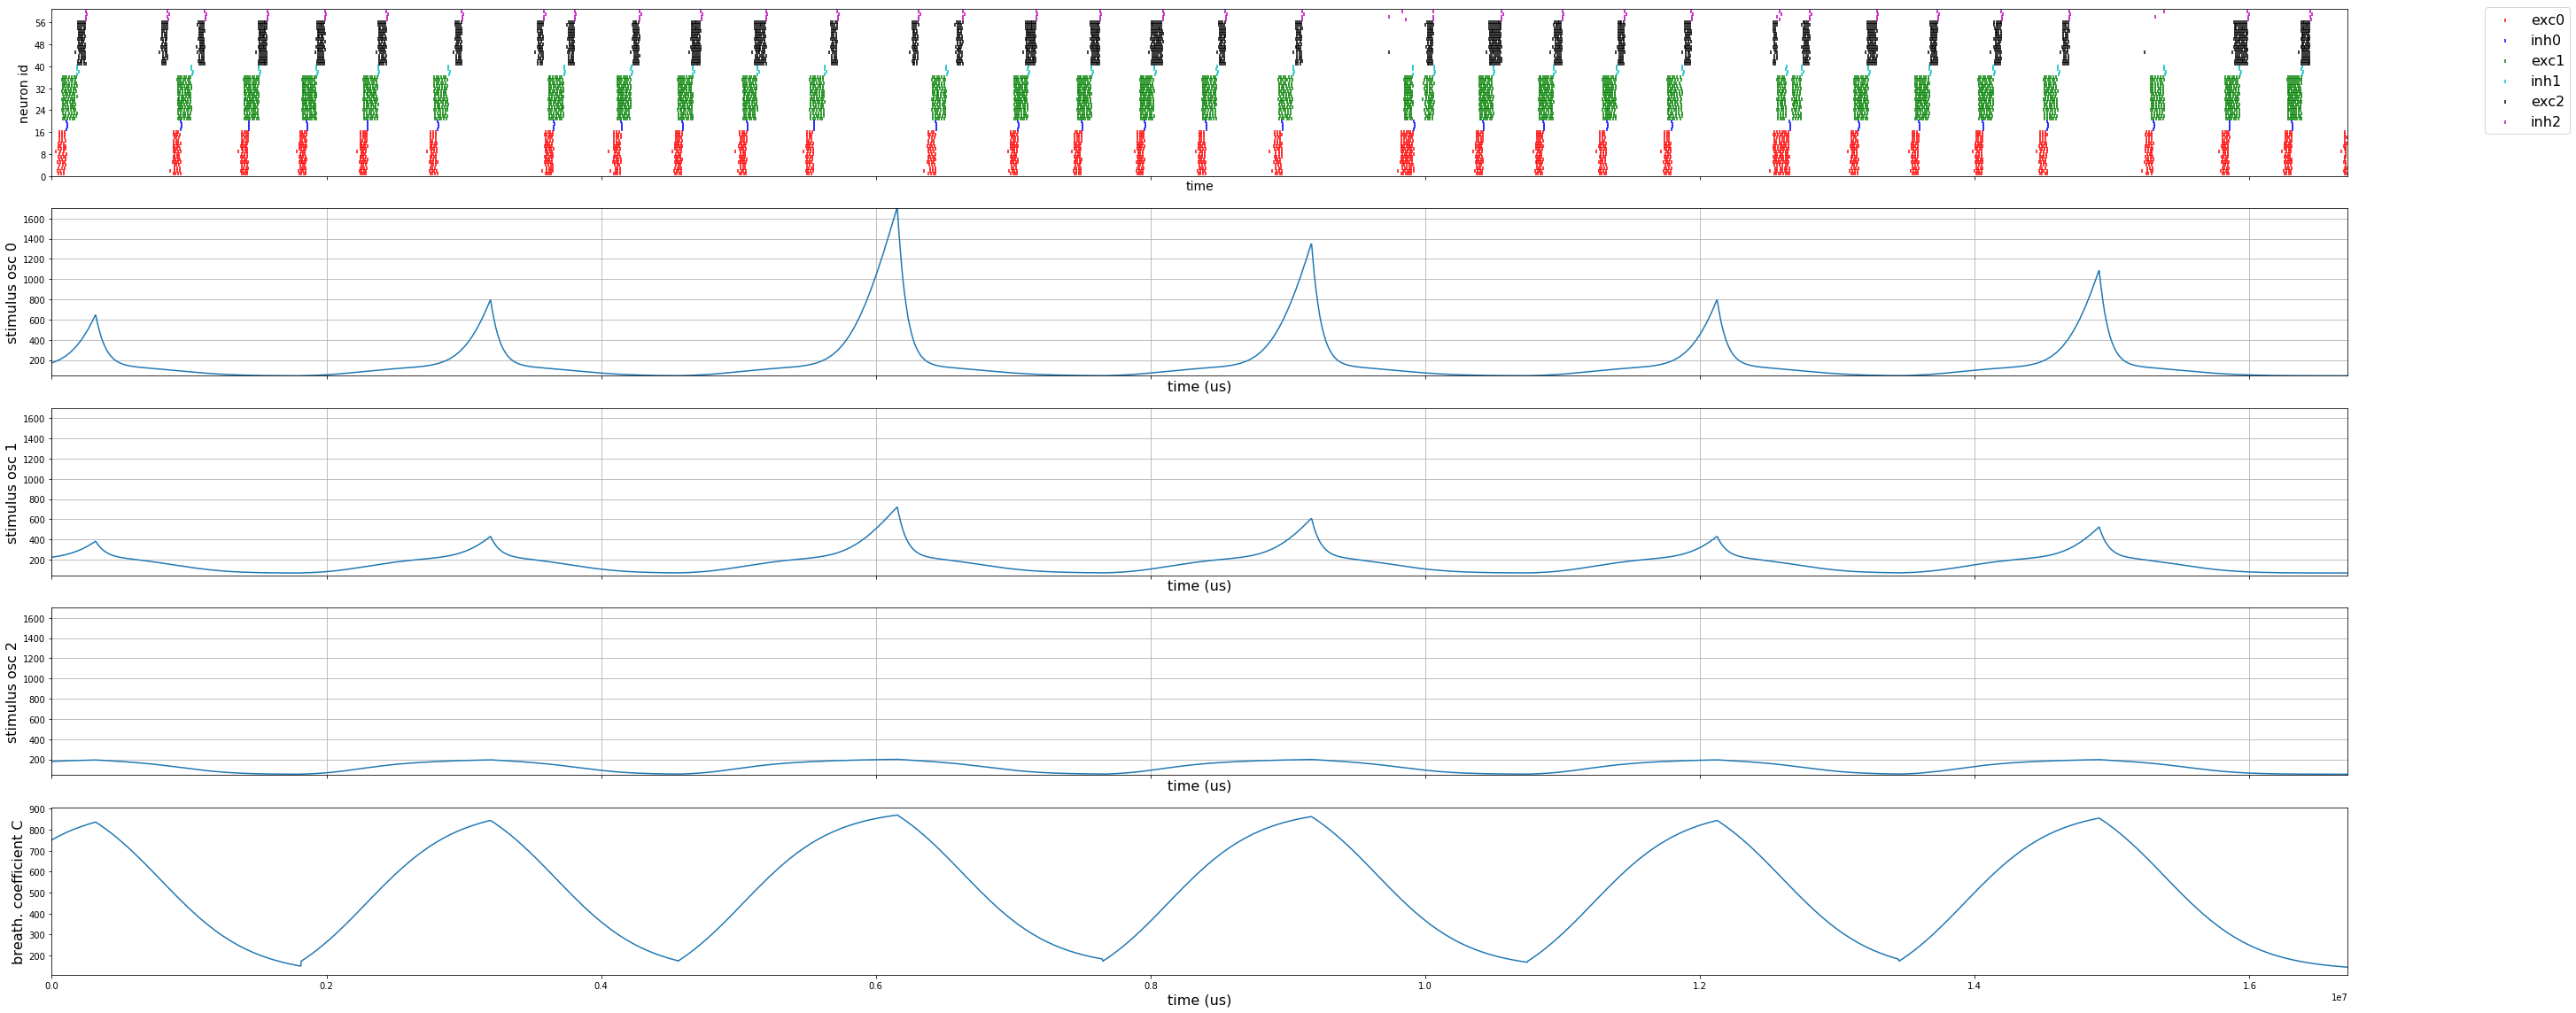

In [18]:
rec_nr = 3
RSAPlt.plot_coupled_RSA_oscillator_summary(MyEMs=MyEMs_per_rec[rec_nr],
                                           dt_run=all_dt_runs[rec_nr],
                                           current_spike_freq_trace_per_osc=spike_freq_trace_per_osc_per_rec[rec_nr],
                                           current_t_spike_freq_trace=t_spike_freq_trace_er_rec[rec_nr],
                                           current_b_coeffs_trace=b_coeffs_trace_per_rec[rec_nr], fontsize_label=16)

## show G(C) for DYNAP-SE data

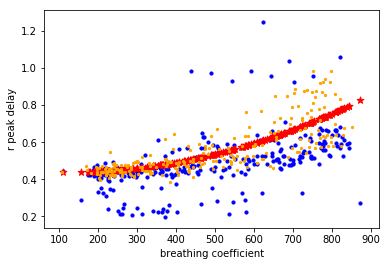

In [19]:
RSAPlt.get_G_fit_for_DYNAPSE(osc_nr_to_show=2, all_t_thrs_per_rec=t_thrs_per_rec, b_coeffs_trace_per_rec=b_coeffs_trace_per_rec)

## save events

In [ ]:
outputfilename = 'Events_RSA.hdf5'
OscEventsSaver().save_events_RSA(outputfilename=outputfilename,
                                 N_osc=N_osc,
                                 n_recs_required=n_recs_required,
                                 all_MyEMs=MyEMs_per_rec,
                                 all_dt_runs=all_dt_runs,
                                 b_coeffs_trace_per_rec=b_coeffs_trace_per_rec,
                                 spike_freq_trace_per_osc_per_rec=spike_freq_trace_per_osc_per_rec,
                                 t_spike_freq_trace_per_rec=t_spike_freq_trace_per_rec,
                                 spike_times_per_osc_per_rec=spike_times_per_osc_per_rec, 
                                 thr_delays_per_osc=thr_delays_per_osc,
                                 adjusting_factors_per_osc=adjusting_factors_per_osc,
                                 scaling_factors=scaling_factors,
                                 step_size_adjusting_factor=step_size_adjusting_factor,
                                 step_size_scaling_factor=step_size_scaling_factor)